In [ ]:
import requests
from bs4 import BeautifulSoup

from selenium import webdriver
from selenium.webdriver import ActionChains
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import NoSuchElementException
import pyperclip

import re
import time
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:.5f}'.format
import seaborn as sns

import koreanize_matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from wordcloud import WordCloud

font_path = '/Users/jieunlee/Documents/3_TECH!T_202305/TECH!T_dataton/nanum-barun-gothic/NanumBarunGothic.ttf'  # 각자 경로에 맞게
fontprop = fm.FontProperties(fname=font_path, size=18)

# **Prediction**

- 종속변수: 구독수 (-> 조회수는 중복 / 좋아요수 및 별점은 각 에프소드에 대한 값)
- 수치형변수: '좋아요수', '조회수', '별점', '회차', '회차(한국)', '별점(한국)', '관심수(한국)', '작가전작개수', '연재기간(태국)', '연재기간(한국)'
- 번주형변수: '장르(태국)', '장르(한국)', '해시태그(한국)',  '완결여부', '웹툰/시리즈구분', 'OSMU여부'

In [ ]:
d = pd.read_csv('최종데이터셋_230920.csv')

In [ ]:
predict_df = d[['좋아요수', '조회수', '별점', '회차', '회차(한국)', '별점(한국)', '관심수(한국)', '작가전작개수', '연재기간(태국)', '연재기간(한국)', 
                '장르(태국)', '완결여부', '웹툰/시리즈구분', 'OSMU여부',
                '구독수']]

In [ ]:
predict_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 877 entries, 0 to 876
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   좋아요수      877 non-null    int64  
 1   조회수       877 non-null    int64  
 2   별점        877 non-null    float64
 3   회차        877 non-null    int64  
 4   회차(한국)    877 non-null    int64  
 5   별점(한국)    593 non-null    float64
 6   관심수(한국)   877 non-null    int64  
 7   작가전작개수    877 non-null    int64  
 8   연재기간(태국)  877 non-null    int64  
 9   연재기간(한국)  593 non-null    float64
 10  장르(태국)    877 non-null    object 
 11  완결여부      593 non-null    object 
 12  웹툰/시리즈구분  593 non-null    object 
 13  OSMU여부    877 non-null    bool   
 14  구독수       877 non-null    int64  
dtypes: bool(1), float64(3), int64(8), object(3)
memory usage: 96.9+ KB


**추가 전처리**

In [ ]:
predict_df.loc[predict_df['완결여부'].notna(), '한국네이버작품'] = 1
predict_df.loc[predict_df['완결여부'].isna(), '한국네이버작품'] = 0

/var/folders/lf/rw90dn5523z_2nzwhfsv6yn40000gn/T/ipykernel_1654/1774227172.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_df.loc[predict_df['완결여부'].notna(), '한국네이버작품'] = 1


In [ ]:
predict_df['별점(한국)'].fillna(predict_df['별점(한국)'].mean(), inplace=True)
predict_df['연재기간(한국)'].fillna(predict_df['연재기간(한국)'].mean(), inplace=True)
predict_df['장르(태국)'].fillna('미정', inplace=True)
predict_df['웹툰/시리즈구분'].fillna('미정', inplace=True)
predict_df['완결여부'].fillna(False, inplace=True)
predict_df['완결여부'].astype('int')
predict_df['OSMU여부'].astype('int')
predict_df['한국네이버작품'].astype('int')

/var/folders/lf/rw90dn5523z_2nzwhfsv6yn40000gn/T/ipykernel_1654/1811234139.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_df['별점(한국)'].fillna(predict_df['별점(한국)'].mean(), inplace=True)
/var/folders/lf/rw90dn5523z_2nzwhfsv6yn40000gn/T/ipykernel_1654/1811234139.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_df['연재기간(한국)'].fillna(predict_df['연재기간(한국)'].mean(), inplace=True)
/var/folders/lf/rw90dn5523z_2nzwhfsv6yn40000gn/T/ipykernel_1654/1811234139.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.

0      1
1      1
2      1
3      1
4      0
      ..
872    0
873    0
874    1
875    1
876    1
Name: 한국네이버작품, Length: 877, dtype: int64

**종속변수 로그변환**

In [ ]:
original_y = predict_df['구독수']
predict_df['구독수'] = np.log1p(predict_df['구독수'])

/var/folders/lf/rw90dn5523z_2nzwhfsv6yn40000gn/T/ipykernel_1654/3727160004.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_df['구독수'] = np.log1p(predict_df['구독수'])


**더미변수 생성**

In [ ]:
# 더미변수 생성
predict_df_ohe = pd.get_dummies(predict_df,columns=['장르(태국)', '웹툰/시리즈구분'])

**회귀**

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
def get_rmse(model):
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test , pred)
    rmse = np.sqrt(mse)
    print('{0} 로그 변환된 RMSE: {1}'.format(model.__class__.__name__,np.round(rmse, 3)))
    return rmse

def get_rmses(models):
    rmses = [ ]
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

In [ ]:
y_target = predict_df_ohe['구독수']
X_features = predict_df_ohe.drop(['구독수'], axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)


/opt/homebrew/Caskroom/miniforge/base/envs/venv/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=8.03296e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


LinearRegression 로그 변환된 RMSE: 0.93
Ridge 로그 변환된 RMSE: 0.932
Lasso 로그 변환된 RMSE: 1.171


[0.9303721978439209, 0.9319724813664977, 1.1707667499740815]

In [ ]:
def get_top_bottom_coef(model):
    # coef_ 속성을 기반으로 Series 객체를 생성. index는 컬럼명. 
    coef = pd.Series(model.coef_, index=X_features.columns)
    
    # + 상위 10개 , - 하위 10개 coefficient 추출하여 반환.
    coef_high = coef.sort_values(ascending=False).head(10)
    coef_low = coef.sort_values(ascending=False).tail(10)
    return coef_high, coef_low

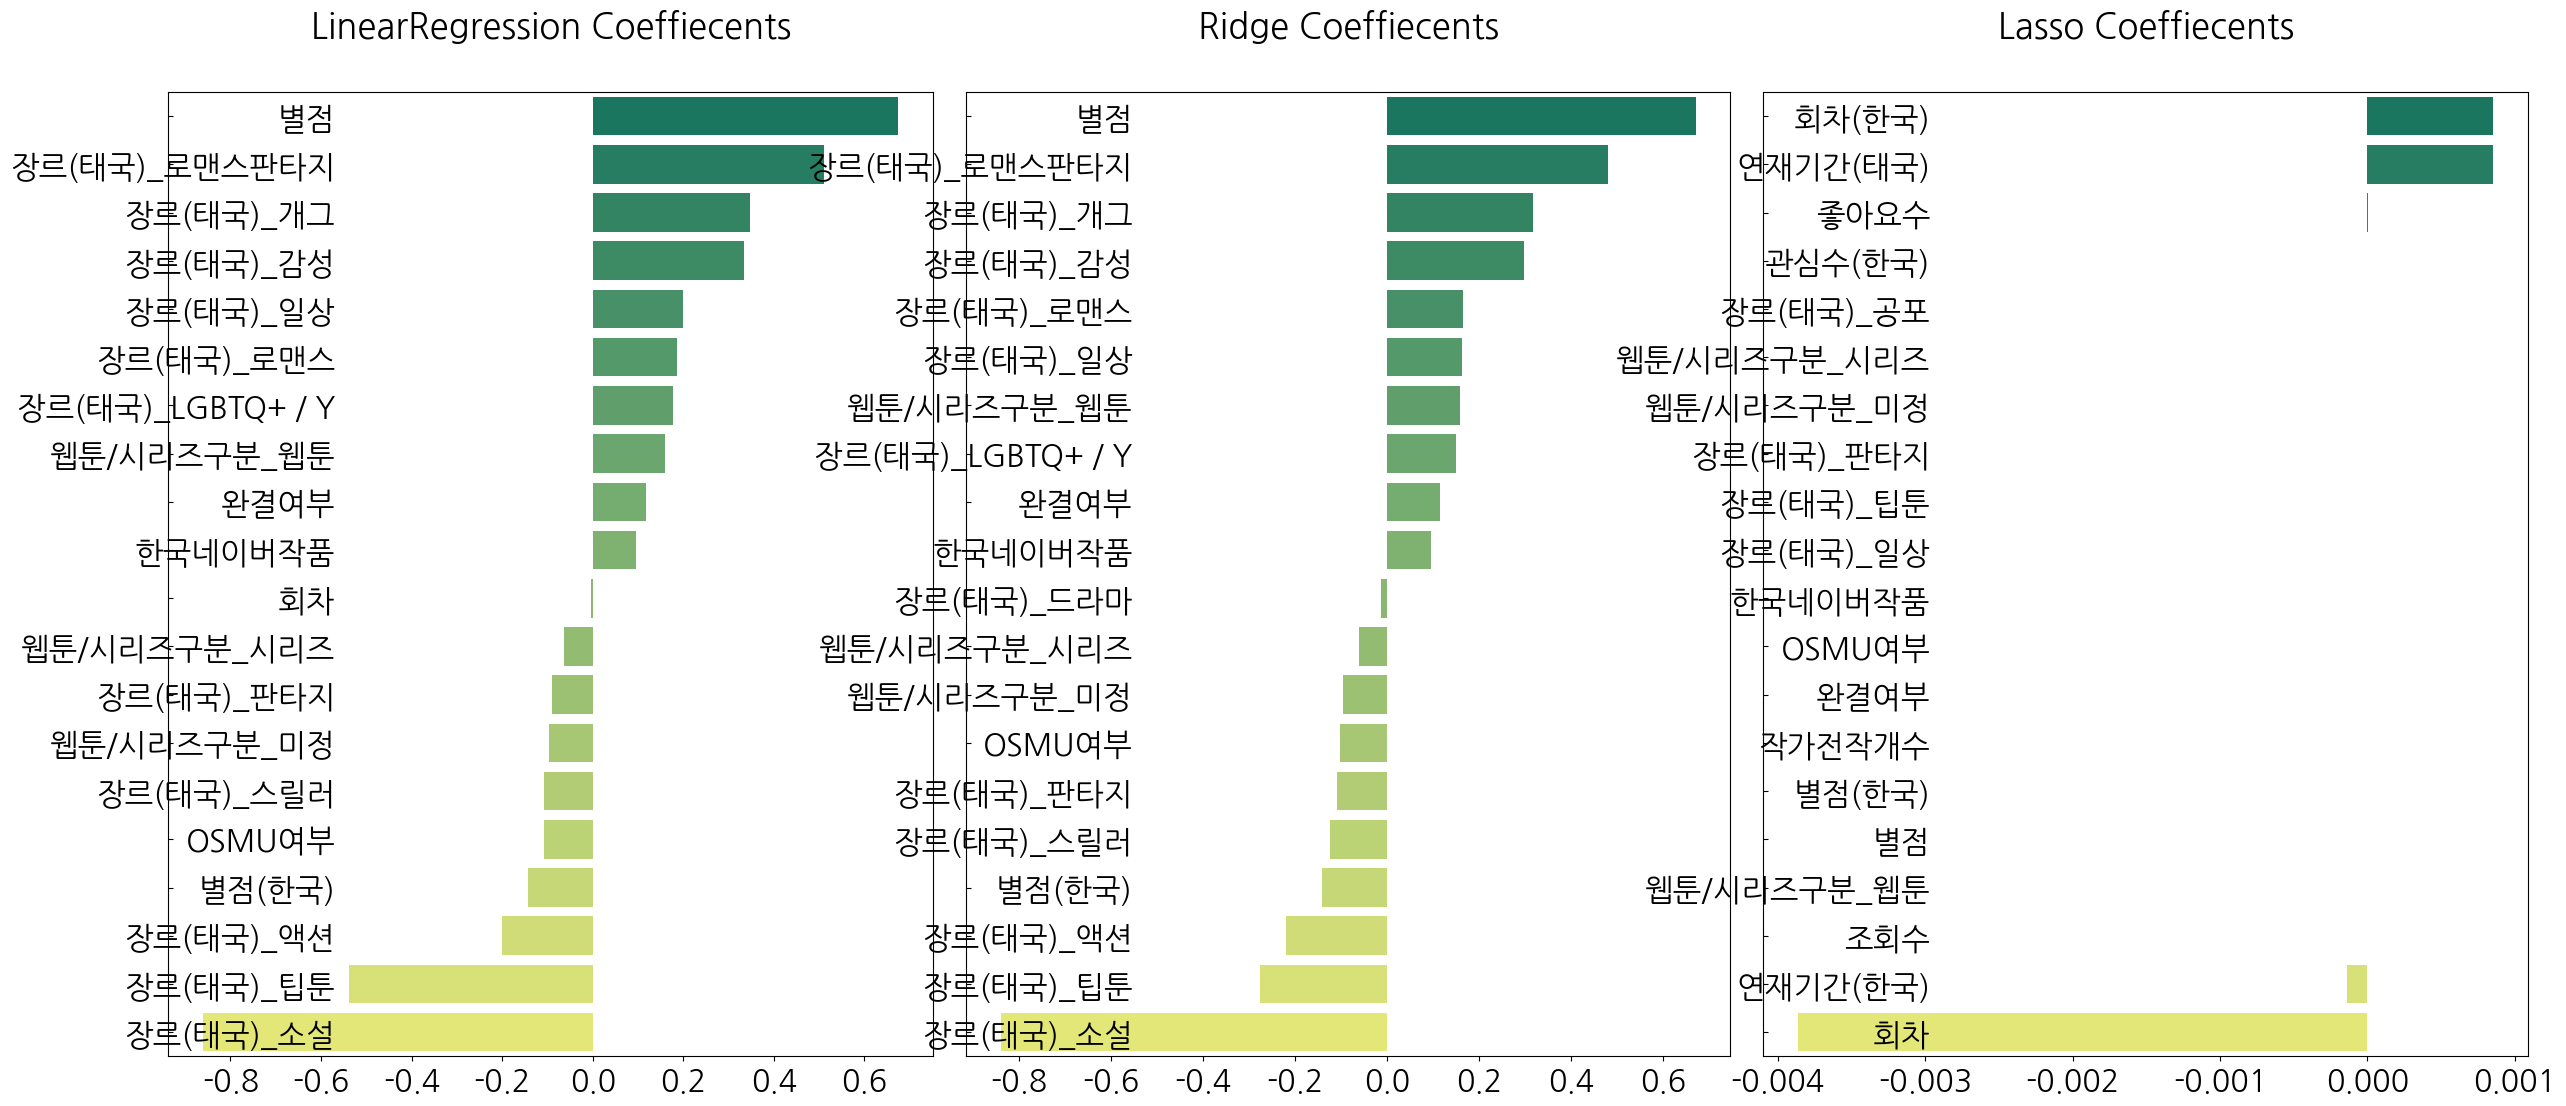

In [ ]:
def visualize_coefficient(models):
    # 3개 회귀 모델의 시각화를 위해 3개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=3)
    fig.tight_layout() 
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 회귀 계수 시각화. 
    for i_num, model in enumerate(models):
        # 상위 10개, 하위 10개 회귀 계수를 구하고, 이를 판다스 concat으로 결합. 
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat( [coef_high , coef_low] )
        # 순차적으로 ax subplot에 barchar로 표현. 한 화면에 표현하기 위해 tick label 위치와 font 크기 조정. 
        axs[i_num].set_title(model.__class__.__name__+' Coeffiecents', size=25, pad=40)
        axs[i_num].tick_params(axis="y",direction="in", pad=-120)
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index, palette='summer', ax=axs[i_num])

# 앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 회귀 계수 시각화.    
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

In [ ]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):
    for model in models:
        # 분할하지 않고 전체 데이터로 cross_val_score( ) 수행. 모델별 CV RMSE값과 평균 RMSE 출력
        rmse_list = np.sqrt(-cross_val_score(model, X_features, y_target,
                                             scoring="neg_mean_squared_error", cv = 5))
        rmse_avg = np.mean(rmse_list)
        print('\n{0} CV RMSE 값 리스트: {1}'.format( model.__class__.__name__, np.round(rmse_list, 3)))
        print('{0} CV 평균 RMSE 값: {1}'.format( model.__class__.__name__, np.round(rmse_avg, 3)))

# 앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 CV RMSE값 출력           
models = [lr_reg, ridge_reg, lasso_reg]
get_avg_rmse_cv(models)


LinearRegression CV RMSE 값 리스트: [0.649 0.867 0.992 1.253 1.016]
LinearRegression CV 평균 RMSE 값: 0.955

Ridge CV RMSE 값 리스트: [0.646 0.868 0.991 1.253 1.017]
Ridge CV 평균 RMSE 값: 0.955


/opt/homebrew/Caskroom/miniforge/base/envs/venv/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=7.80517e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/Caskroom/miniforge/base/envs/venv/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=1.20517e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/Caskroom/miniforge/base/envs/venv/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=1.1214e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/Caskroom/miniforge/base/envs/venv/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=8.2603e-19): result may not be accurate.
  return li


Lasso CV RMSE 값 리스트: [0.616 1.027 1.046 1.481 1.185]
Lasso CV 평균 RMSE 값: 1.071


In [ ]:
from sklearn.model_selection import GridSearchCV

def get_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params, 
                              scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X_features, y_target)
    rmse = np.sqrt(-1* grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE 값: {1}, 최적 alpha:{2}'.format(model.__class__.__name__,
                                        np.round(rmse, 4), grid_model.best_params_))
    return grid_model.best_estimator_

ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
best_rige = get_best_params(ridge_reg, ridge_params)
best_lasso = get_best_params(lasso_reg, lasso_params)

/opt/homebrew/Caskroom/miniforge/base/envs/venv/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=3.94145e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/Caskroom/miniforge/base/envs/venv/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=6.08096e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/Caskroom/miniforge/base/envs/venv/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=5.6572e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/Caskroom/miniforge/base/envs/venv/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=4.15968e-20): result may not be accurate.
  return l

Ridge 5 CV 시 최적 평균 RMSE 값: 0.9752, 최적 alpha:{'alpha': 5}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.9759, 최적 alpha:{'alpha': 0.001}


/opt/homebrew/Caskroom/miniforge/base/envs/venv/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=9.17125e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


LinearRegression 로그 변환된 RMSE: 0.93
Ridge 로그 변환된 RMSE: 0.947
Lasso 로그 변환된 RMSE: 0.934


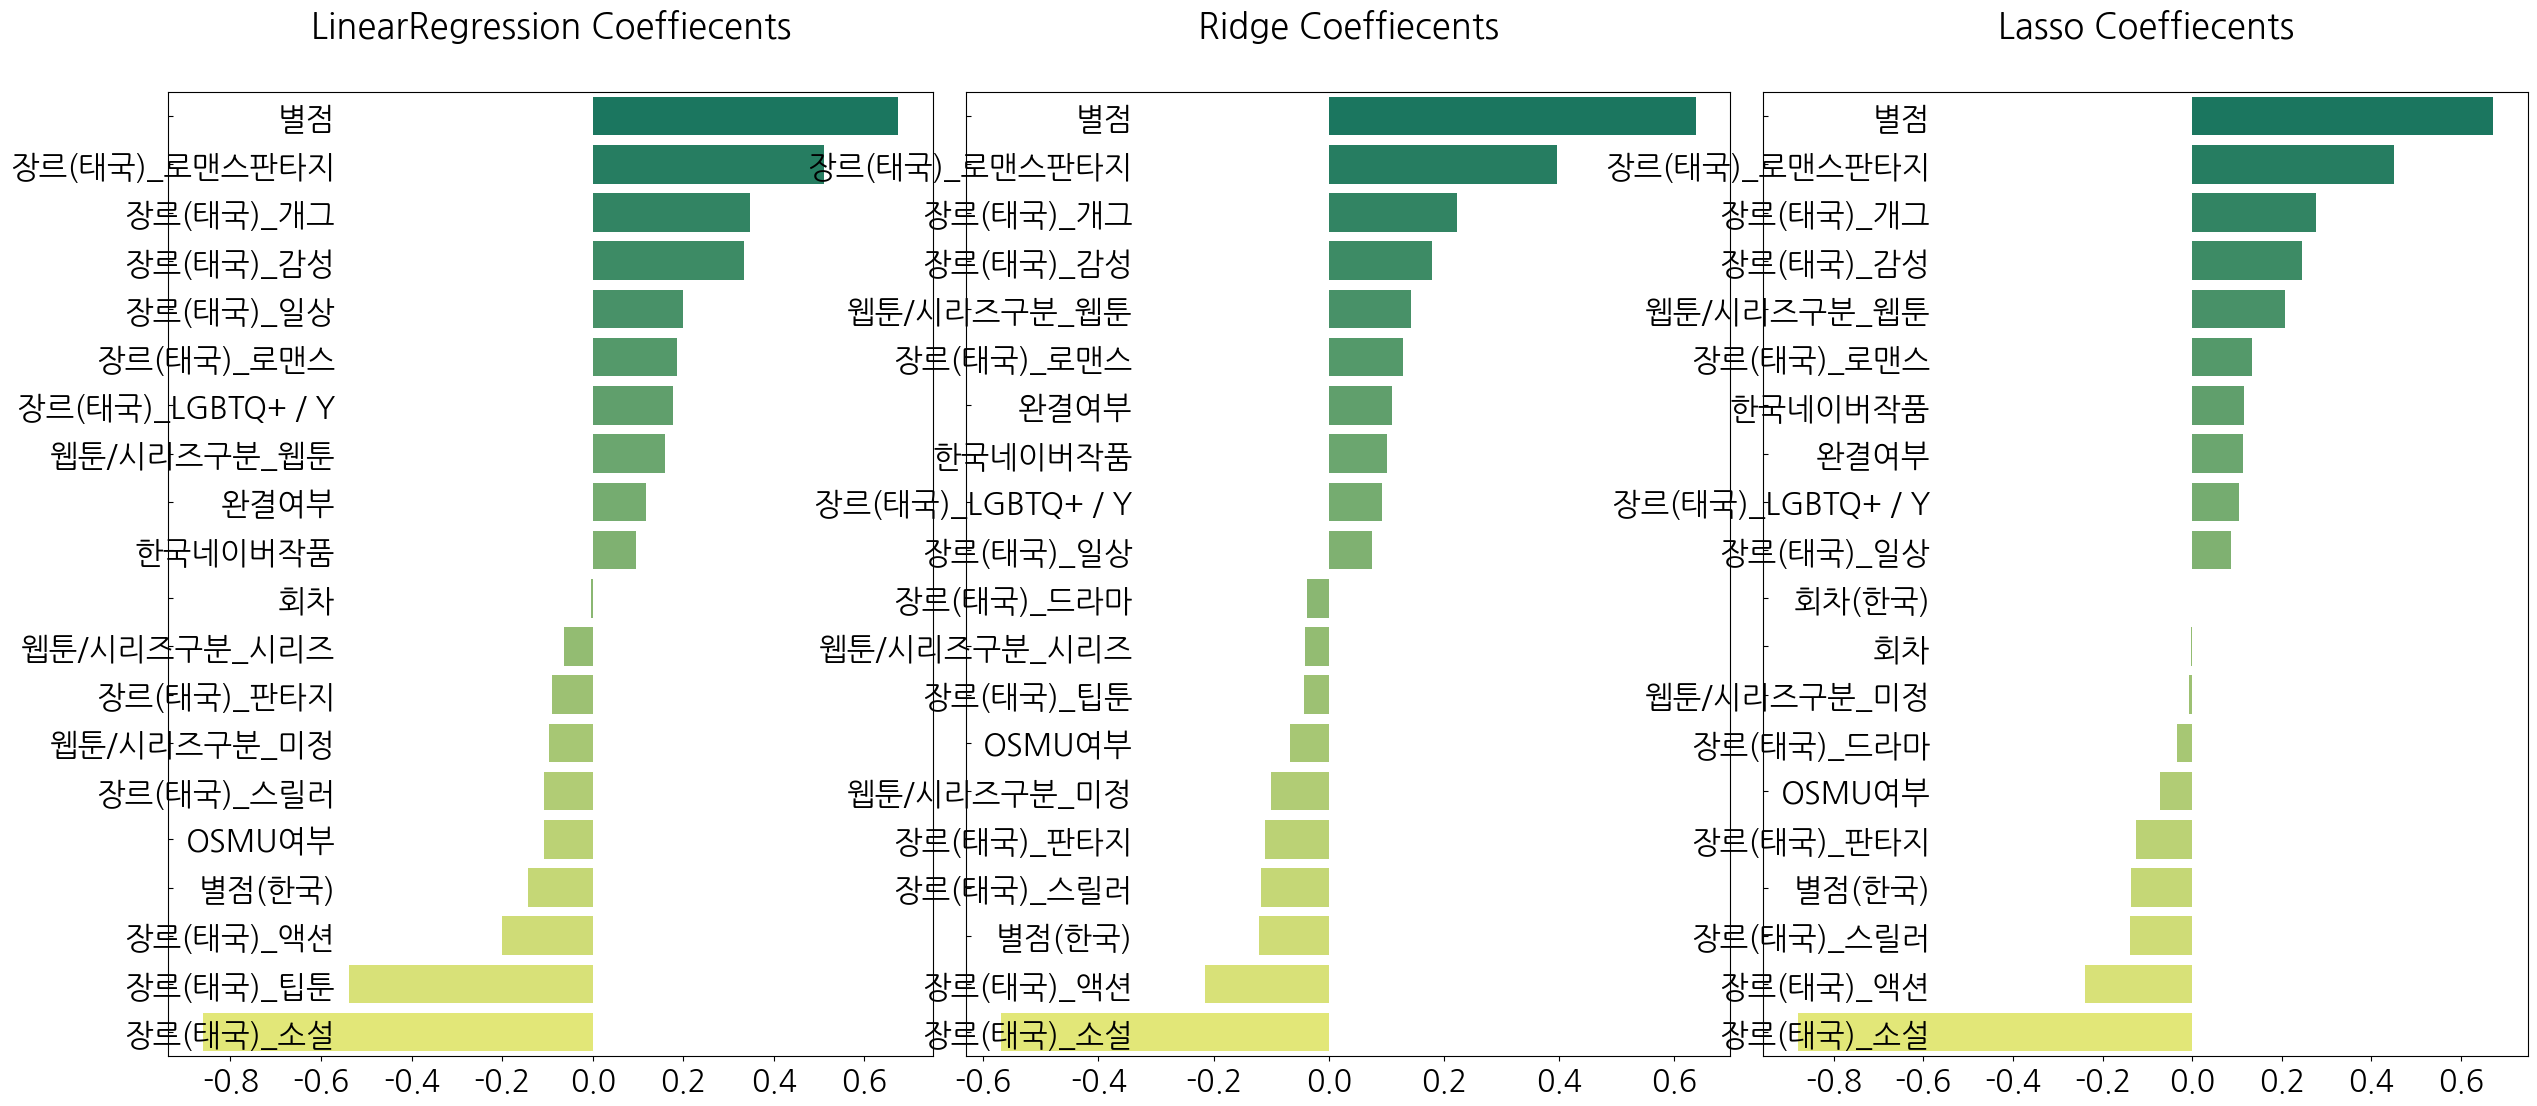

In [ ]:
# 앞의 최적화 alpha값으로 학습데이터로 학습, 테스트 데이터로 예측 및 평가 수행. 
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=12)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화 
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

In [ ]:
from scipy.stats import skew

# object가 아닌 숫자형 피쳐의 컬럼 index 객체 추출.
features_index = predict_df.dtypes[predict_df.dtypes != 'object'].index
# predict_df_ohe에 컬럼 index를 [ ]로 입력하면 해당하는 컬럼 데이터 셋 반환. apply lambda로 skew( )호출 
skew_features = predict_df[features_index].apply(lambda x : skew(x))
# skew 정도가 5 이상인 컬럼들만 추출. 
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending=False))

조회수        7.95392
회차         6.35736
좋아요수       5.78205
OSMU여부     4.94410
회차(한국)     4.05851
연재기간(한국)   3.90197
관심수(한국)    3.74528
연재기간(태국)   2.87890
작가전작개수     2.47243
dtype: float64


In [ ]:
predict_df[skew_features_top.index] = np.log1p(predict_df[skew_features_top.index])

/var/folders/lf/rw90dn5523z_2nzwhfsv6yn40000gn/T/ipykernel_1654/1716930309.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_df[skew_features_top.index] = np.log1p(predict_df[skew_features_top.index])


In [ ]:
# Skew가 높은 피처들을 로그 변환 했으므로 다시 원-핫 인코딩 적용 및 피처/타겟 데이터 셋 생성,
predict_df_ohe = pd.get_dummies(predict_df)
y_target = predict_df_ohe['구독수']
X_features = predict_df_ohe.drop('구독수',axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# 피처들을 로그 변환 후 다시 최적 하이퍼 파라미터와 RMSE 출력
ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
best_ridge = get_best_params(ridge_reg, ridge_params)
best_lasso = get_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값: 0.2911, 최적 alpha:{'alpha': 1}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.2912, 최적 alpha:{'alpha': 0.001}


LinearRegression 로그 변환된 RMSE: 0.297
Ridge 로그 변환된 RMSE: 0.307
Lasso 로그 변환된 RMSE: 0.302


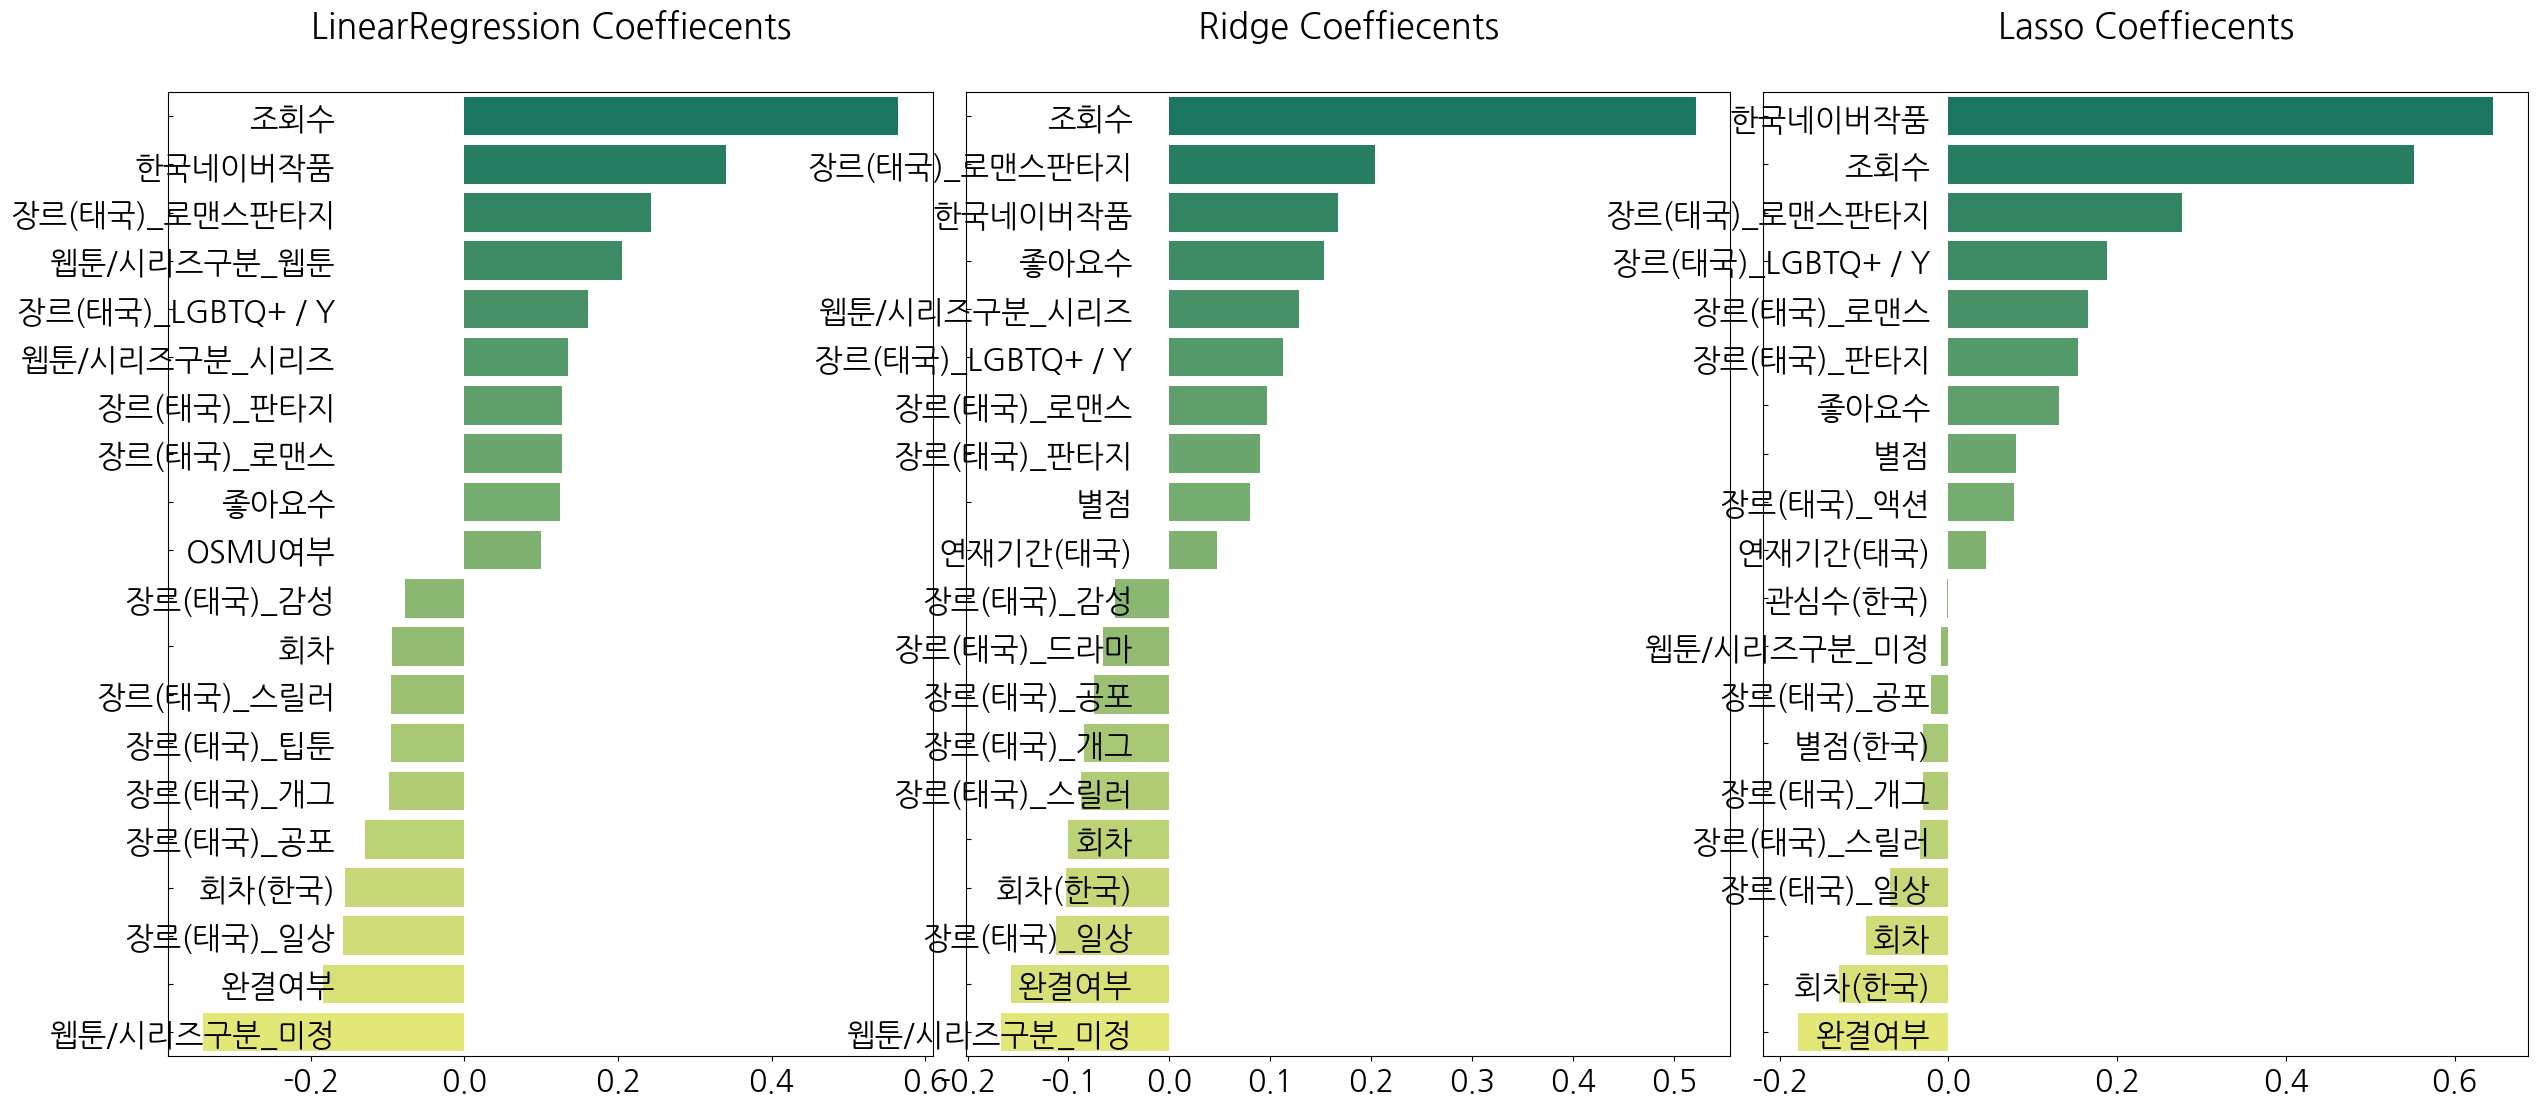

In [ ]:
# 앞의 최적화 alpha값으로 학습데이터로 학습, 테스트 데이터로 예측 및 평가 수행. 
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=10)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화 
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

In [ ]:
from xgboost import XGBRegressor

xgb_params = {'n_estimators':[1000]}
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, 
                       colsample_bytree=0.5, subsample=0.8)
best_xgb = get_best_params(xgb_reg, xgb_params)

XGBRegressor 5 CV 시 최적 평균 RMSE 값: 0.3296, 최적 alpha:{'n_estimators': 1000}


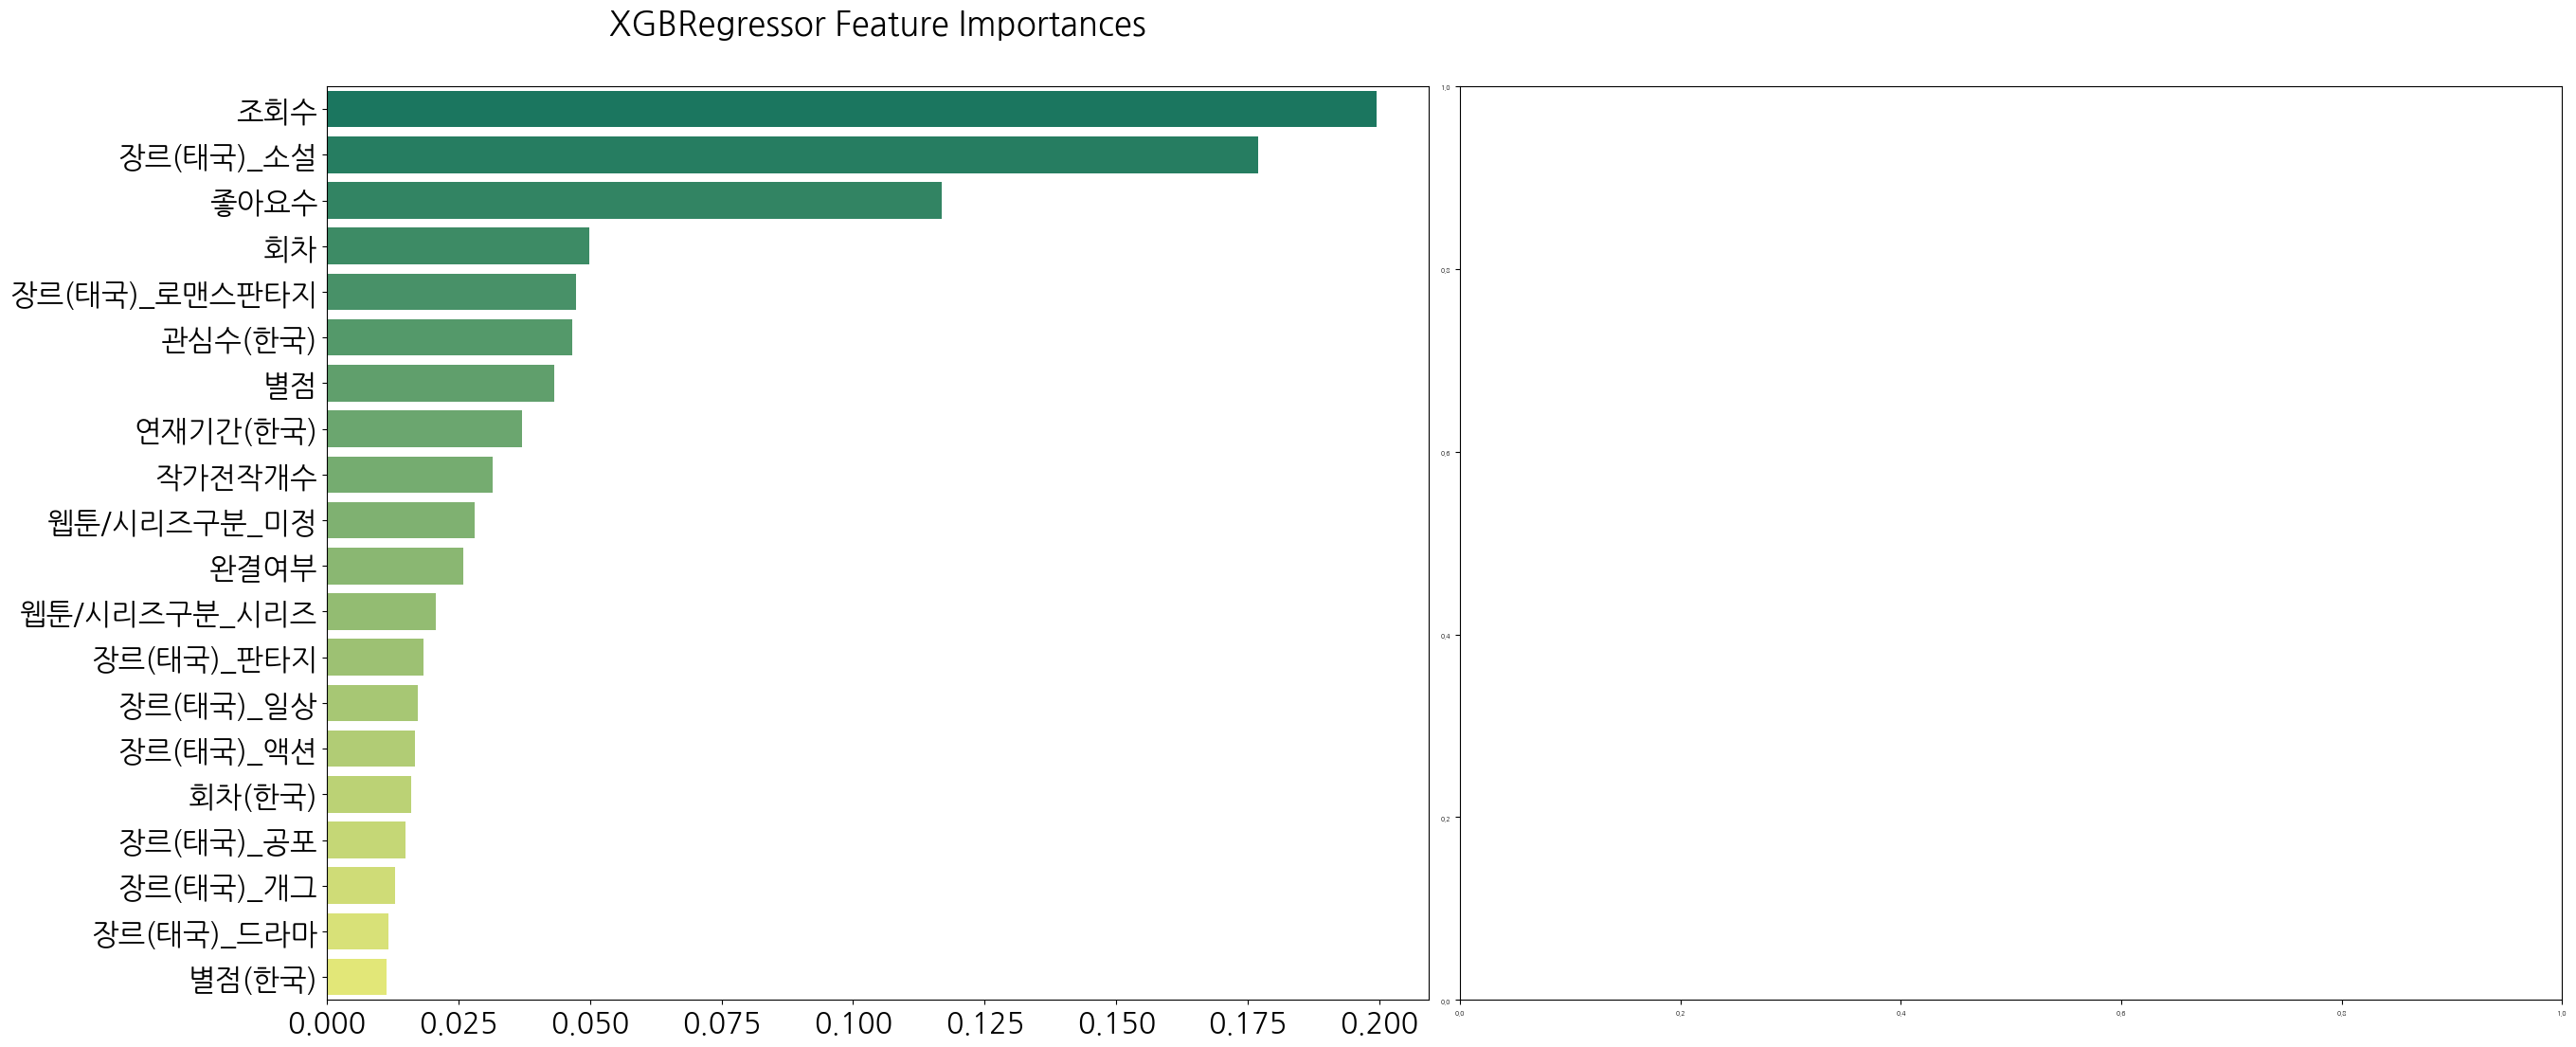

In [ ]:
# 모델의 중요도 상위 20개의 피처명과 그때의 중요도값을 Series로 반환.
def get_top_features(model):
    ftr_importances_values = model.feature_importances_
    ftr_importances = pd.Series(ftr_importances_values, index=X_features.columns  )
    ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
    return ftr_top20

def visualize_ftr_importances(models):
    # 2개 회귀 모델의 시각화를 위해 2개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=2)
    fig.tight_layout() 
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 피처 중요도 시각화. 
    for i_num, model in enumerate(models):
        # 중요도 상위 20개의 피처명과 그때의 중요도값 추출 
        ftr_top20 = get_top_features(model)
        axs[i_num].set_title(model.__class__.__name__+' Feature Importances', size=25, pad=40)
        #font 크기 조정.
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=ftr_top20.values, y=ftr_top20.index , palette='summer', ax=axs[i_num])

# 앞 예제에서 get_best_params( )가 반환한 GridSearchCV로 최적화된 모델의 피처 중요도 시각화    
models = [best_xgb]
visualize_ftr_importances(models)

In [ ]:
def get_rmse_pred(preds):
    for key in preds.keys():
        pred_value = preds[key]
        mse = mean_squared_error(y_test , pred_value)
        rmse = np.sqrt(mse)
        print('{0} 모델의 RMSE: {1}'.format(key, rmse))

# 개별 모델의 학습
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)
# 개별 모델 예측
ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

# 개별 모델 예측값 혼합으로 최종 예측값 도출
pred = 0.4 * ridge_pred + 0.6 * lasso_pred
preds = {'최종 혼합': pred,
         'Ridge': ridge_pred,
         'Lasso': lasso_pred}
#최종 혼합 모델, 개별모델의 RMSE 값 출력
get_rmse_pred(preds)


최종 혼합 모델의 RMSE: 0.3036465374368449
Ridge 모델의 RMSE: 0.3058098604655621
Lasso 모델의 RMSE: 0.3024999408988093


**스태킹 모델을 통한 회귀 에측**

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수. 
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
    # 지정된 n_folds값으로 KFold 생성.
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=0)
    #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화 
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')
    
    for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출 
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        X_tr = X_train_n[train_index] 
        y_tr = y_train_n[train_index] 
        X_te = X_train_n[valid_index]  
        
        #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
        model.fit(X_tr , y_tr)       
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장. 
        test_pred[:, folder_counter] = model.predict(X_test_n)
            
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성 
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)    
    
    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean

In [ ]:
# get_stacking_base_datasets( )은 넘파이 ndarray를 인자로 사용하므로 DataFrame을 넘파이로 변환. 
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

# 각 개별 기반(Base)모델이 생성한 학습용/테스트용 데이터 반환. 
ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 5)  

Ridge  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
Lasso  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
XGBRegressor  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 


In [ ]:
# 개별 모델이 반환한 학습 및 테스트용 데이터 세트를 Stacking 형태로 결합.  
Stack_final_X_train = np.concatenate((ridge_train, lasso_train, 
                                      xgb_train), axis=1)
Stack_final_X_test = np.concatenate((ridge_test, lasso_test, 
                                     xgb_test), axis=1)

# 최종 메타 모델은 라쏘 모델을 적용. 
meta_model_lasso = Lasso(alpha=0.0005)

#기반 모델의 예측값을 기반으로 새롭게 만들어진 학습 및 테스트용 데이터로 예측하고 RMSE 측정.
meta_model_lasso.fit(Stack_final_X_train, y_train)
final = meta_model_lasso.predict(Stack_final_X_test)
mse = mean_squared_error(y_test , final)
rmse = np.sqrt(mse)
print('스태킹 회귀 모델의 최종 RMSE 값은:', rmse)

스태킹 회귀 모델의 최종 RMSE 값은: 0.2952963877358504


/opt/homebrew/Caskroom/miniforge/base/envs/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.227e-01, tolerance: 1.209e-01
  model = cd_fast.enet_coordinate_descent(


## **상관관계**

In [ ]:
df_copy = d.copy()

In [ ]:
df_copy.drop(['Unnamed: 0'], axis=1, inplace=True)

In [ ]:
num_features = ['좋아요수', '조회수', '별점', '회차', '회차(한국)', '별점(한국)', '관심수(한국)', '작가전작개수', '연재기간(태국)', '연재기간(한국)', '구독수']
cat_features = ['장르(태국)', '장르(한국)', '해시태그(한국)',  '완결여부', '웹툰/시리즈구분', 'OSMU여부']

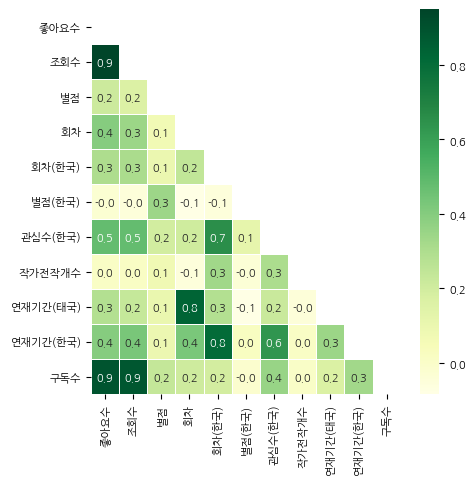

In [ ]:
#correlation map
fig, ax = plt.subplots(figsize=(5, 5))

plt.rc('font', size=8)
plt.xticks(size=8)
plt.yticks(size=8)

mask = np.zeros_like(df_copy[num_features].corr(), dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(df_copy[num_features].corr(), annot=True, mask=mask, cmap='YlGn', linewidths=.5, fmt= '.1f', ax=ax)

plt.show()

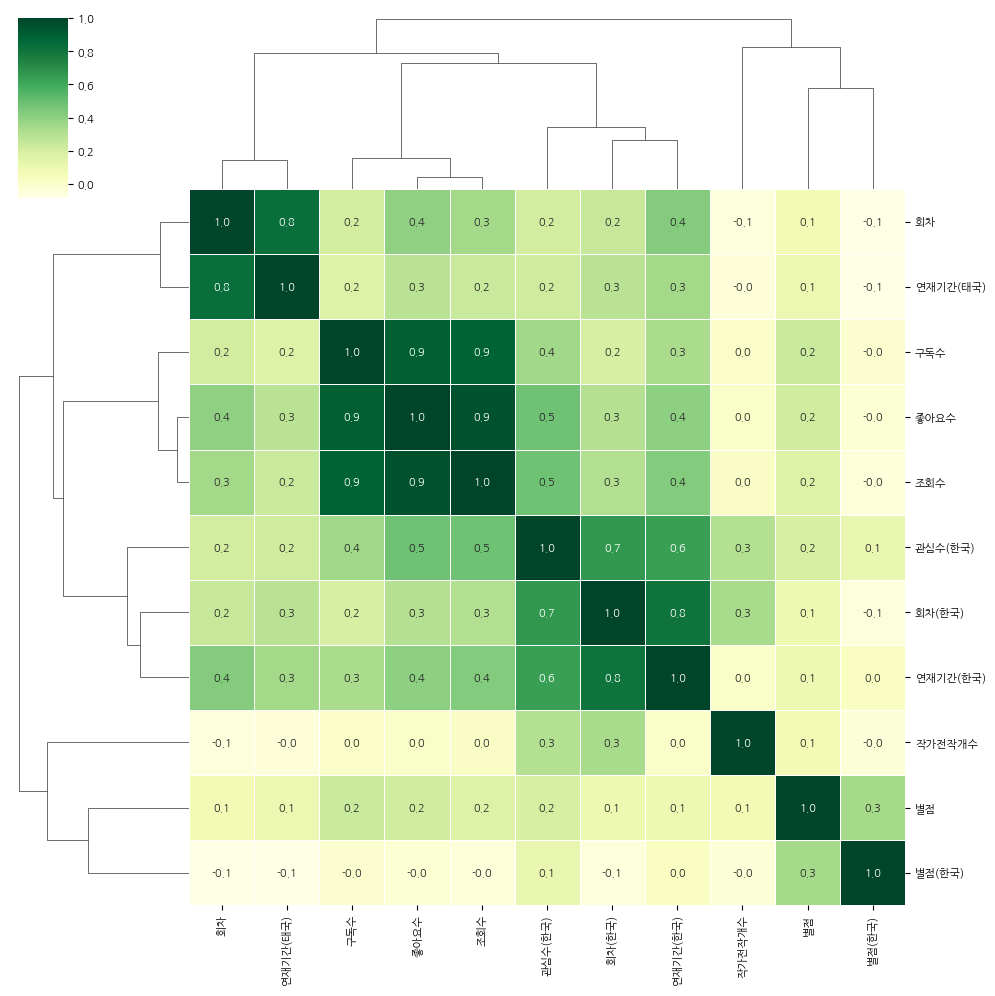

In [ ]:
sns.clustermap(df_copy[num_features].corr(), annot=True, cmap='YlGn', linewidths=.5, fmt= '.1f')